## Su-Schrieffer-Heeger Model

In the lecture, we explored how topology helps stabilize entanglement in quantum computing. In this notebook, we'll get practical experience by diagonalizing the Su-Schrieffer-Heeger model and learning how to classify its phases as either topological or trivial.

## Load modules 

In [1]:
# First we load the libraries
import numpy as np
import scipy as sp
from sklearn.utils import shuffle

## Machine learning related libraries:
import torch
import torch.nn as nn            # base class used to develop all neural network models
from torch.utils.data import DataLoader # easy and organized data loading to the ML model
from torch.utils.data import Dataset #for nice loadable dataset creation

# Set up plotting
import matplotlib.pyplot as plt
plt.style.use('./SciencePlots-APS.mplstyle')


## Data generation

In this step, we generate the wave function of the SSH Hamiltonian on a finite lattice. We've done this for you, so you won't need to spend time on it during the tutorial, but feel free to explore it later!

### Exact diagonalization and eigenvector sorting

In [2]:
# FUNCTION: returns Eigenvalues and Eigenvectors of SSH model Hamiltonian

def eig_sort( v, w, N ):
    ''' function to calculate eigen values and sort them
    v, w: parameters of the SSH model
    N: number of unit cells
    '''
    
    # Create matrix for the (off diagonal) hopping terms
    off_diag = np.zeros(2*N-1)
    off_diag[0:2*N-1:2] = v
    off_diag[1:2*N-1:2] = w
    
    # Exact diagonalization:
    H = sp.sparse.diags([off_diag, off_diag], (1, -1)).toarray()
    eigvals, eigvecs = np.linalg.eig(H)
    
    # Make each row in eigvecs_invert as an wavefunction:
    eigvecs_invert = np.array([eigvecs[:,i] for  i in range(2*N)])
    
    # Sort the eigen values and eigen functions according to the eigen valus:
    indices = eigvals.argsort()
    sorted_eigvals = eigvals[indices]
    sorted_eigvecs = eigvecs_invert[indices]

    return sorted_eigvals, sorted_eigvecs

In [3]:
# Number of unit cells
N = 8 

# Range of coefficients v and w we want to sample for our training set
v = np.arange(1, 100+1, 0.01)   
w = np.arange(100, 0, -0.01)    

# Number of (v,w) pairs: 
size_dataset = v.size

# Sorted eigenvectors and eigenvalues
eigs = np.vectorize(eig_sort,otypes = [np.ndarray,np.ndarray],excluded = 'N')
eig_values, eig_function = eigs(v,w,N)

# Here we create the labels: topological for the first half of the training set,
# Trivial for the second half
topo = np.array([ [1,0] for i in range(size_dataset//2)])
trivial = np.array([ [0,1] for i in range(size_dataset//2)])
labels = np.concatenate([topo, trivial])

# check the size of the dataset you just created
print('size of dataset:', size_dataset)

size of dataset: 10000


We have now generated our data set.

The eigenfunctions, which we will train on, are saved in the `eig_function` array, and the labels are saved in the `labels` array.

Below, you can select a Hamiltonian using the `H_ho` index and plot all eigenmodes.

See if you can spot the two topological eigenstates!

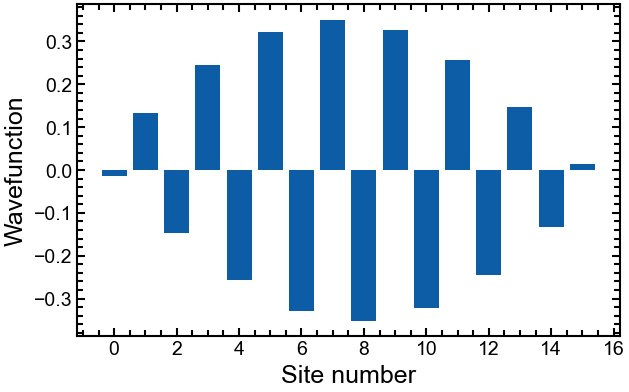

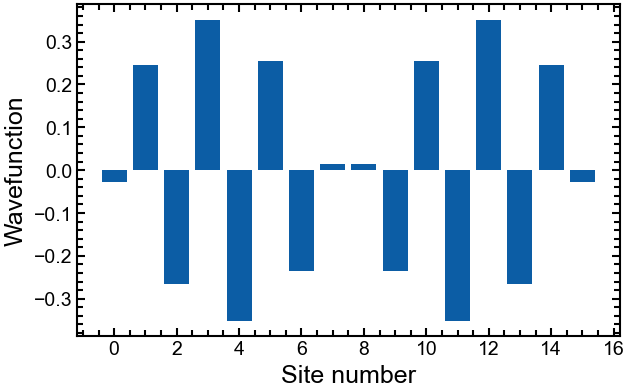

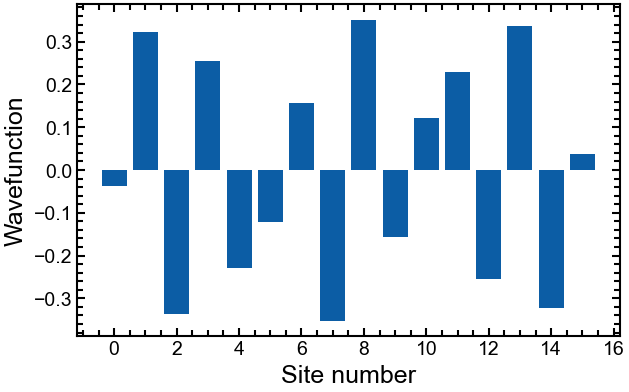

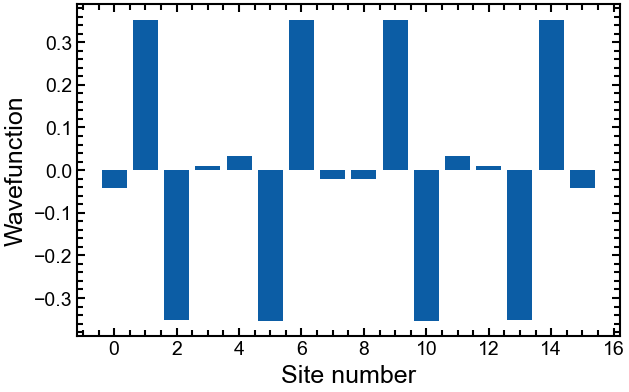

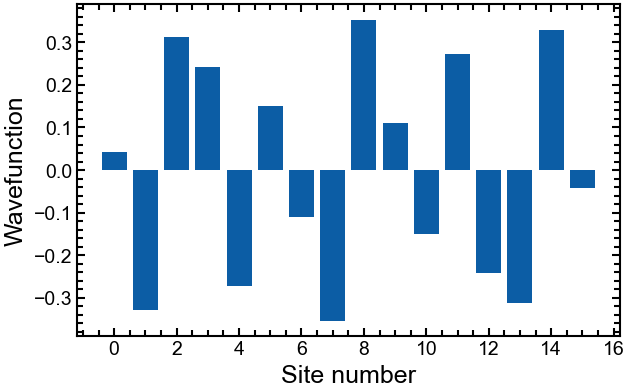

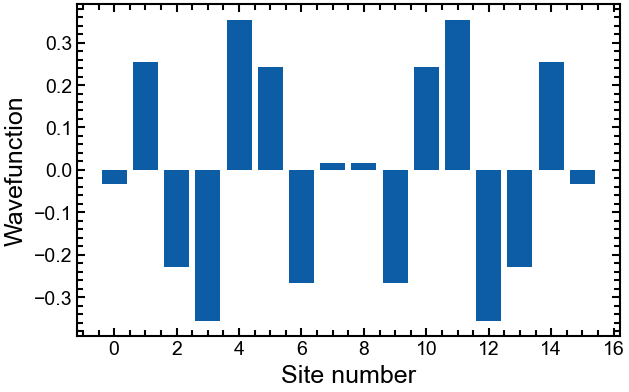

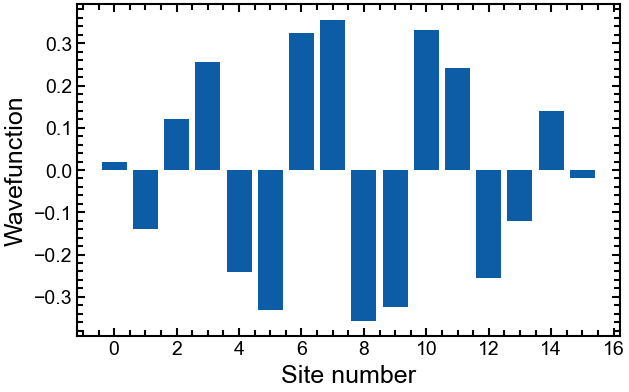

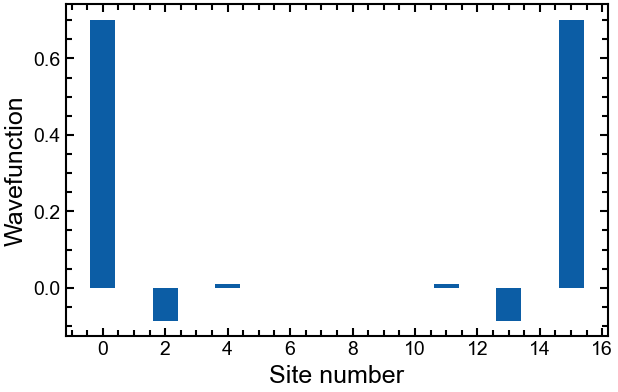

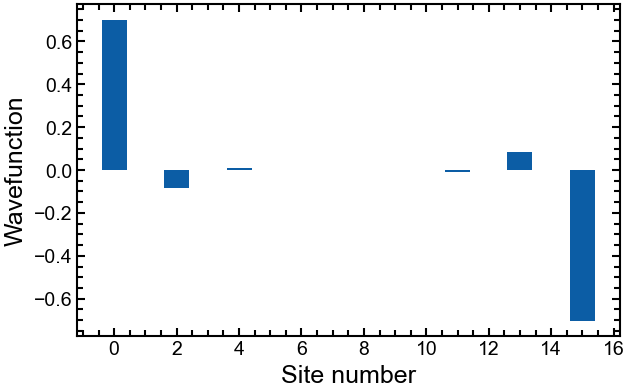

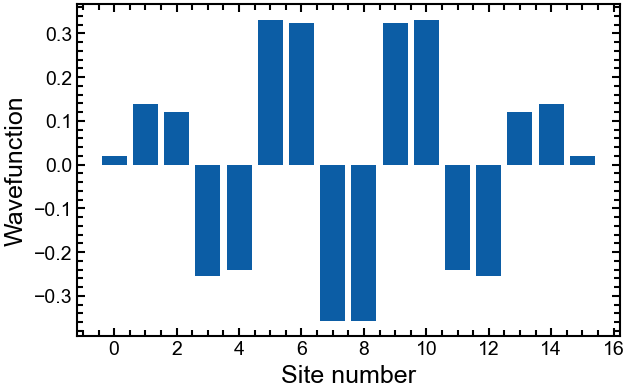

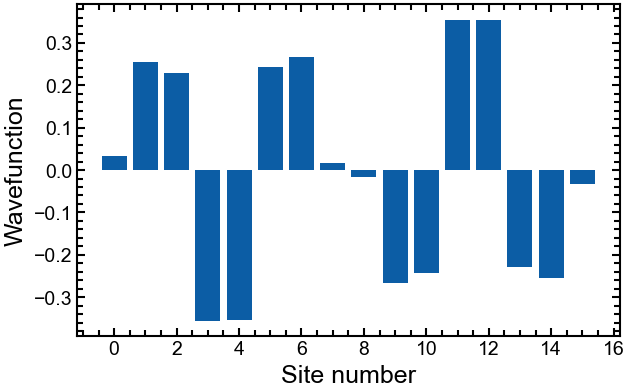

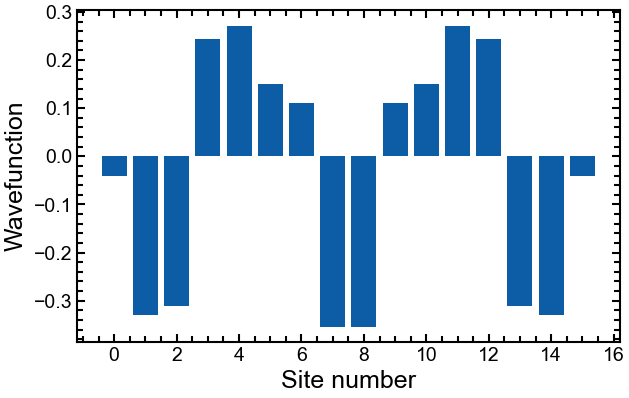

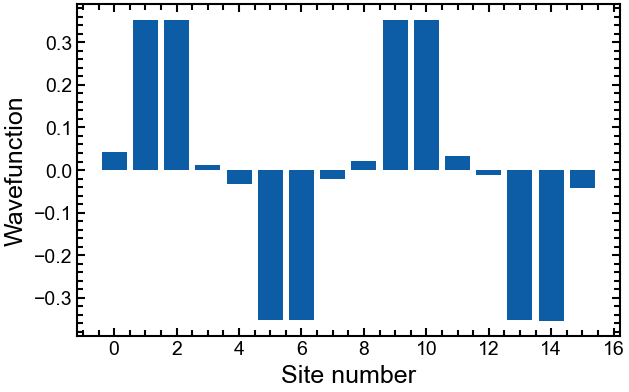

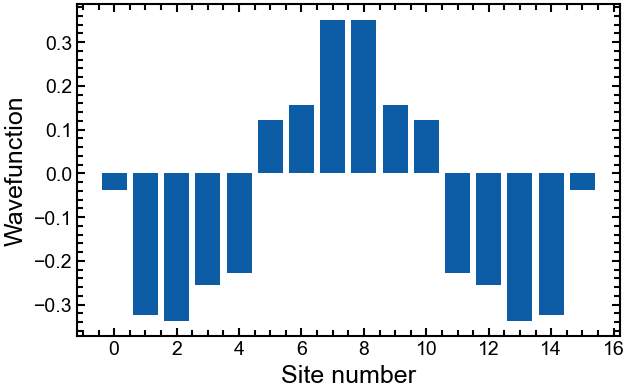

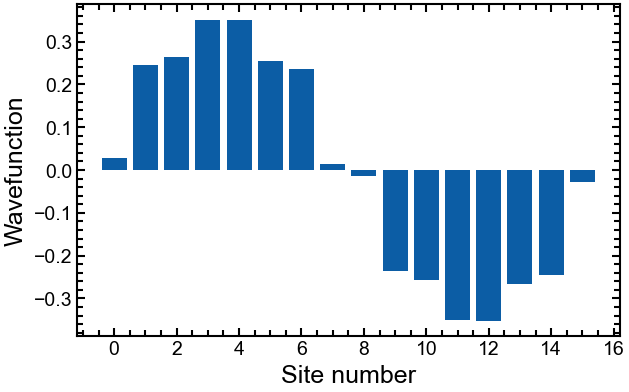

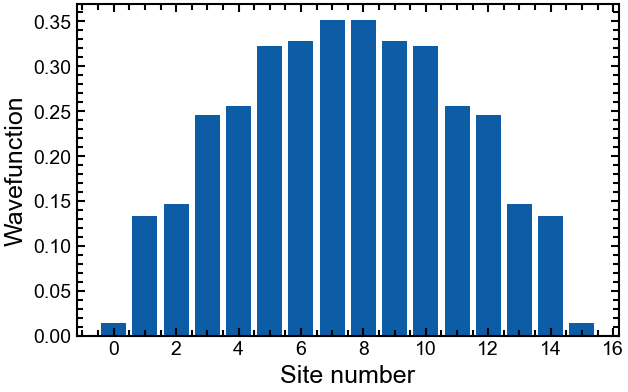

In [4]:
# Hamiltonian number for which we want to plot the eigenvectors
H_no = 1000

for i in range(2*N):
    plt.figure(i)
    plt.bar(np.arange(0,2*N), eig_function[H_no][i])
    plt.xlabel('Site number')
    plt.ylabel('Wavefunction')
    plt.show()

## 2. Creating dataset for ML training

Here we use the the data generation we designed above to create a training and test set
we can easily load into the ML model.

*Creating your dataset well is the MOST important thing when dealing with real ML challenges!*

In [5]:
# Number of Hamiltonians in the total set
NUM_HAMILTONIAN = size_dataset    
REBUILD_DATA = True                     # set to true to one once, then back to false unless you want to change something in your training data.

class datafunc_fullSSH():
    def __init__(self, NUM_HAMILTONIAN):
        # We input the number of Hamiltonians when initializing the class
        self.NUM_HAMILTONIAN = NUM_HAMILTONIAN
        # Define system size variable
        self.SYSTEM_SIZE = 2 * N
        # Combine the label and training data
        self.training_data = []           # empty list, will populate data and labels later on.

    def make_training_data(self):
        for H_no in range(self.NUM_HAMILTONIAN):
            # Flattened 16 eigenstates has shape 16*16 =256
            temp_lattice_collec = np.array([eig_function[H_no][i] for i in range(len(eig_function[1]))])
            wind_num = labels[H_no]
            self.training_data.append([temp_lattice_collec.flatten(), wind_num])
        
        self.training_data = np.array(self.training_data, dtype=object)   #shuffles ordering of the data!
        np.random.shuffle(self.training_data)
        np.save("./ssh/training_data_finalSSH.npy", self.training_data)

if REBUILD_DATA:
    dataclass_fullSSH = datafunc_fullSSH(NUM_HAMILTONIAN)
    dataclass_fullSSH.make_training_data()

In [6]:
# Load the training data
training_data_fullSSH = np.load("./ssh/training_data_finalSSH.npy", allow_pickle=True)
print(len(training_data_fullSSH))

SYSTEM_SIZE = 2 * N
VAL_PCT = 0.2  # reserve 20% of our data for the validation set

# Convert lists to NumPy arrays first
X_fullSSH_np = np.array([i[0] for i in training_data_fullSSH])
y_fullSSH_np = np.array([i[1] for i in training_data_fullSSH])

# Convert NumPy arrays to PyTorch tensors
X_fullSSH = torch.Tensor(X_fullSSH_np)
y_fullSSH = torch.Tensor(y_fullSSH_np)

val_size = int(len(X_fullSSH) * VAL_PCT)
print(val_size)

# Separate the data into training and test data
train_X_fullSSH = X_fullSSH[:-val_size]
train_y_fullSSH = y_fullSSH[:-val_size]

test_X_fullSSH = X_fullSSH[-val_size:]
test_y_fullSSH = y_fullSSH[-val_size:]

print("len(train_X_fullSSH), len(test_X_fullSSH) is ", len(train_X_fullSSH), len(test_X_fullSSH))

10000
2000
len(train_X_fullSSH), len(test_X_fullSSH) is  8000 2000


In [7]:
# final step: we take our training and labeled data and create a custom dataset class
# that we will then pass on to the dataloader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        # we pass data and labels when we initialize the class
        self.data = data
        self.labels = labels

    def __len__(self):
        # function that outputs length of dataset
        return len(self.data)

    def __getitem__(self, idx):
        #function that outputs data item with index idx
        # return data, label
        data_idx = self.data[idx]
        label = self.labels[idx][0].type(torch.LongTensor) #label must be output as datatype=Long (also known as int64)
        return data_idx, label

In [8]:
# training dataset
train_dataset_class = CustomDataset(train_X_fullSSH, train_y_fullSSH)

In [9]:
# test dataset
test_dataset_class = CustomDataset(test_X_fullSSH, test_y_fullSSH)

Shape of X: torch.Size([25, 256])
Shape of y: torch.Size([25]) torch.int64
tensor(0)


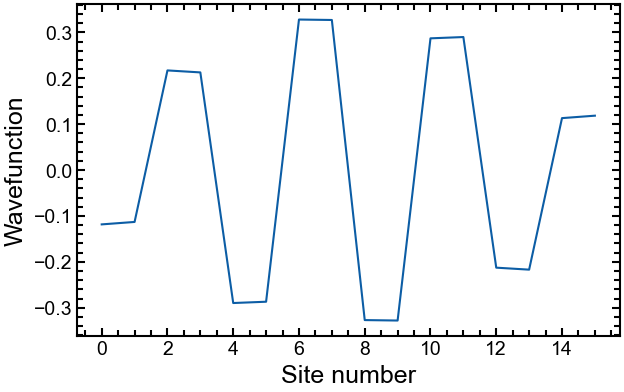

In [10]:
# we pass the dataset as an argument to DataLoader -> automatic batching, sampling, shuffling etc.

batch_size = 25

# create data loaders

train_dataloader = DataLoader(train_dataset_class, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset_class, batch_size = batch_size)

# check that the dataloader works correctly and give the right shape and type
for X, y in train_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(y[2])
    plt.plot(X[2,8*16:9*16])
    plt.xlabel('Site number')
    plt.ylabel('Wavefunction')
    plt.show()
    break

## 3. Build and train a ML model

This section is where we finally define our machine learning model

In [11]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model (FINALLY!)
# One example of how to do that: input size is 2Nx2N = 16x16 = 256, followed by
# two fully connected layers with ReLU activation function and binary (topo/trivial) output

# we define a class for the neural network
# torch requires this class to have a method .forward(x)
# it is convention to define the network during initialization of the class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,2)
        )
        
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# here we initialize an instance of the class
model = NeuralNetwork().to(device)
# print the status of the model
# the print command is inherited from nn.Module in the definition of the network
print(model)
        

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [12]:
# optimizing the model parameters
# to train the model we need a LOSS FUNCTION and an OPTIMIZER

loss_fn = nn.CrossEntropyLoss() # we use Cross Entropy as loss
optimizer = torch.optim.SGD(model.parameters(),lr=1e-2) # The optimizer is stochastic gradient descent 

In [13]:
# define the train and test loss accumulation
train_loss_dnn = []
train_acc_dnn = []
test_loss_dnn = []
test_acc_dnn = []

# define training function: make predicition on data set batch,
# backpropagate the error and adjust model parameters
def train(dataloader, model, loss_fn, optimizer, train_loss, train_acc):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    model.train()
    running_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #compute prediction error
        pred = model(X)
        loss = loss_fn(pred,y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # collect the accuracy:
        running_loss += loss.item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()

        if batch % 25==0:
            loss,current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    running_loss /= num_batches
    correct /= size

    train_acc.append(correct)
    train_loss.append(running_loss)

#check performance against the test data set
def test(dataloader,model,loss_fn,test_loss, test_acc):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            running_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    running_loss /= num_batches
    correct /= size

    test_acc.append(correct)
    test_loss.append(running_loss)
    print(f"Test Error: \n Accuracy {(100*correct):>0.1f}%, Avg loss:{running_loss:>8f}\n")

In [14]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------")
    train(train_dataloader,model,loss_fn,optimizer, train_loss_dnn, train_acc_dnn)
    test(test_dataloader,model,loss_fn, test_loss_dnn, test_acc_dnn)
print("Done!")

Epoch 1
 -------------------
loss: 0.692409 [    0/ 8000]
loss: 0.677811 [  625/ 8000]
loss: 0.690085 [ 1250/ 8000]
loss: 0.689967 [ 1875/ 8000]
loss: 0.685784 [ 2500/ 8000]
loss: 0.678104 [ 3125/ 8000]
loss: 0.674048 [ 3750/ 8000]
loss: 0.682441 [ 4375/ 8000]
loss: 0.677991 [ 5000/ 8000]
loss: 0.675831 [ 5625/ 8000]
loss: 0.665449 [ 6250/ 8000]
loss: 0.658933 [ 6875/ 8000]
loss: 0.658594 [ 7500/ 8000]
Test Error: 
 Accuracy 74.4%, Avg loss:0.652278

Epoch 2
 -------------------
loss: 0.656178 [    0/ 8000]
loss: 0.625724 [  625/ 8000]
loss: 0.646152 [ 1250/ 8000]
loss: 0.628933 [ 1875/ 8000]
loss: 0.643965 [ 2500/ 8000]
loss: 0.575094 [ 3125/ 8000]
loss: 0.587184 [ 3750/ 8000]
loss: 0.612320 [ 4375/ 8000]
loss: 0.608346 [ 5000/ 8000]
loss: 0.625146 [ 5625/ 8000]
loss: 0.544958 [ 6250/ 8000]
loss: 0.519828 [ 6875/ 8000]
loss: 0.511142 [ 7500/ 8000]
Test Error: 
 Accuracy 84.8%, Avg loss:0.501788

Epoch 3
 -------------------
loss: 0.518383 [    0/ 8000]
loss: 0.452149 [  625/ 8000]
los

In [15]:
def create_acc_loss_graph(train_acc,train_loss, test_acc, test_loss):
    '''
    '''
    fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
    fig.set_size_inches(9, 3)
    ax1, ax2 = axes[0], axes[1]

    ax1.plot(train_acc,'-o',label="train", markersize=4)
    ax1.plot(test_acc,'--+',label="test", markersize=4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc=3)

    ax2.plot(train_loss,'-o',label="train", markersize=4)
    ax2.plot(test_loss,'--+',label=" test", markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc=1)

    #plot parameters
    ax1.set_ylim(0, np.max([np.max(train_acc),np.max(test_acc)])+0.1)
    ax2.set_ylim(-0.1, np.max([np.max(train_loss),np.max(test_loss)])+0.1)
    ax1.grid(True, which='both',linewidth=0.1)
    ax2.grid(True, which='both',linewidth=0.1)
    plt.tight_layout()
    plt.show()

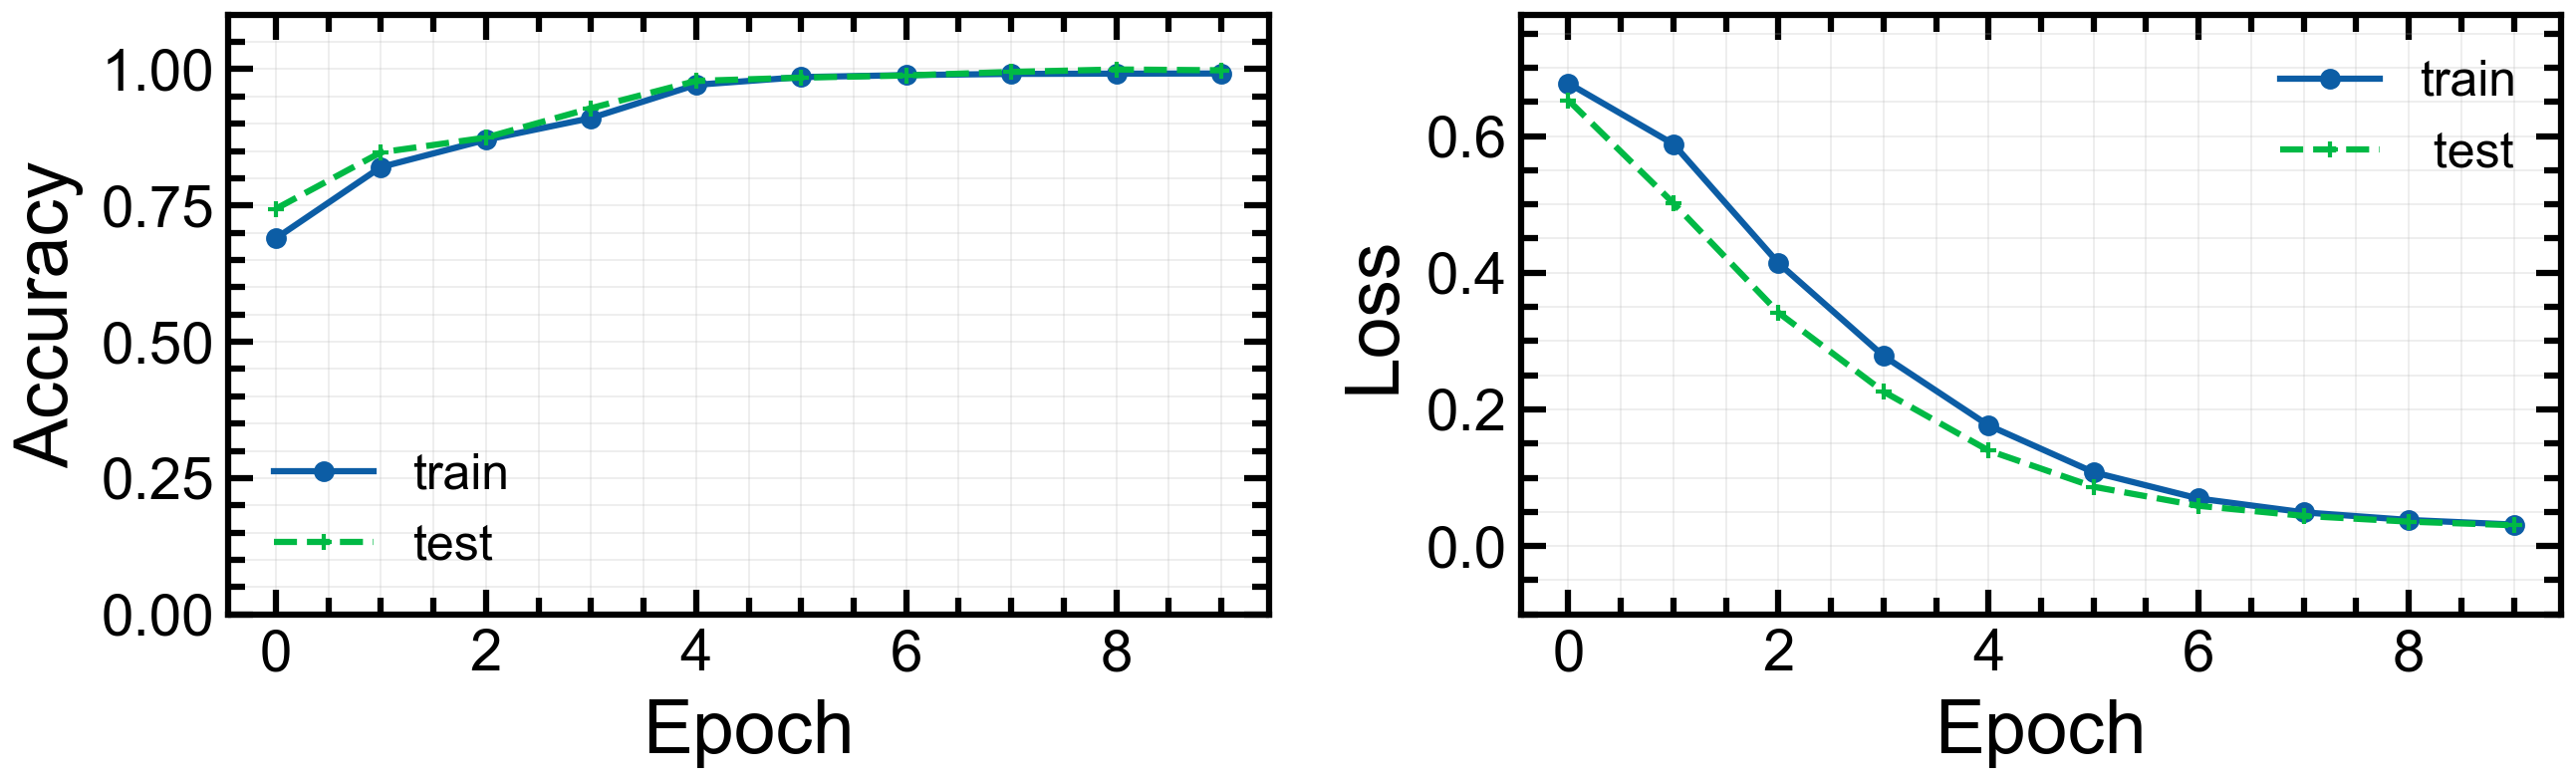

In [16]:
create_acc_loss_graph(train_acc_dnn,train_loss_dnn, test_acc_dnn, test_loss_dnn)

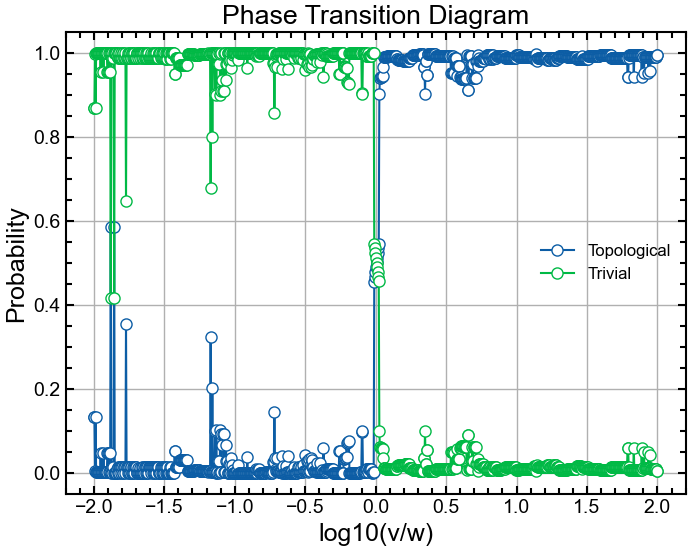

In [28]:
# Sample points in log10(v/w) space
log_v_over_w = torch.linspace(-2, 2, 1000)  # adjust range if needed
v_values = 10 ** log_v_over_w
w_values = torch.ones_like(v_values)

# Create input data (16 eigenstates as a 256-element vector)
input_data = []
for v, w in zip(v_values, w_values):
    _, eig_function = eig_sort(v.item(), w.item(), N)  # Calculate eigenvectors
    temp_lattice_collec = np.array([eig_function[i] for i in range(len(eig_function))])
    input_data.append(temp_lattice_collec.flatten())

# Stack into a single NumPy array then convert to tensor
input_data = torch.Tensor(np.stack(input_data)).to(device) 

# Make predictions
with torch.no_grad():
    predictions = model(input_data)

# Extract probabilities for each phase
topo_prob = torch.softmax(predictions, dim=1)[:, 0]  # Probability of topological phase

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(log_v_over_w, topo_prob, '-o', ms=8, mfc='w', label='Topological')
plt.plot(log_v_over_w, 1 - topo_prob, '-o', ms=8, mfc='w', label='Trivial',)
plt.xlabel('log10(v/w)')
plt.ylabel('Probability')
plt.legend()
plt.title('Phase Transition Diagram')
plt.grid(True)